In [1]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import xarray as xr

from sklearn.model_selection import train_test_split

import torch
import torch.nn as nn
import torch.optim as optim

device = "cuda" if torch.cuda.is_available() else "cpu"
print(device)

cuda


In [2]:
from google.colab import drive
drive.mount('/content/drive')

from pathlib import Path
dirpath_root = Path('/content/drive/MyDrive/repo/pytorch_test')


Mounted at /content/drive


In [9]:
fname = 'rates_npops_2_nmodels_512_npts_32_seed_113_ws_1_uni_r_0.1_9.9_dt_0.25_nt_100'

data0 = xr.open_dataset(dirpath_root / 'data' / f'{fname}.nc')
print(data0.sizes)

data = data0.stack(mp=('model', 'point'), create_index=False)
data = data.assign_coords(mp=np.arange(data.sizes['mp']))
data = data.transpose('mp', 'pop', 'pop_in')

# Features
X = data['H'] / 10
X = torch.from_numpy(X.values).type(torch.float)
W = data['W'].values.reshape(-1, 4)
W = torch.from_numpy(W).type(torch.float)
X = torch.cat((X, W), dim=1)

# Target
y = data['R']
y = torch.from_numpy(y.values).type(torch.float)

Frozen({'model': 512, 'point': 32, 'pop': 2, 'pop_in': 2})


In [10]:
df_x = pd.DataFrame(X.numpy(), columns=['h1', 'h2', 'w11', 'w12', 'w21', 'w22'])
df_y = pd.DataFrame(y.numpy(), columns=['r1', 'r2'])
df = pd.concat([df_x, df_y], axis=1)
df

,h1,h2,w11,w12,w21,w22,r1,r2
0,0.023047,0.026136,0.703971,0.789864,-0.852193,-0.127013,1.351242,5.743407
1,0.107399,-0.654190,0.703971,0.789864,-0.852193,-0.127013,8.336615,4.364182
2,0.255044,-0.308467,0.703971,0.789864,-0.852193,-0.127013,6.919923,6.809453
3,0.335537,-0.205604,0.703971,0.789864,-0.852193,-0.127013,6.966354,7.741004
4,0.475636,0.212086,0.703971,0.789864,-0.852193,-0.127013,6.398944,9.518057
...,...,...,...,...,...,...,...,...
16379,-0.464682,-0.000592,0.418896,0.057804,0.539725,-0.815277,2.553436,2.661670
16380,-0.740660,0.476152,0.418896,0.057804,0.539725,-0.815277,1.221722,5.467205
16381,-0.227240,0.005650,0.418896,0.057804,0.539725,-0.815277,7.812185,2.863439
16382,-0.807063,-0.065296,0.418896,0.057804,0.539725,-0.815277,0.336725,2.252885


In [11]:
df.std(axis=0)

,0
h1,0.580496
h2,0.565291
w11,0.567030
w12,0.592166
w21,0.575557
w22,0.562649
r1,2.827523
r2,2.823079


In [15]:
# Hyper-parameters
HIDDEN_SZ = 32
NLAYERS_HID = 1

n_feat = X.shape[1]
n_out = 2

# Define the model
layers = [nn.Linear(n_feat, HIDDEN_SZ), nn.Tanh()]
for _ in range(NLAYERS_HID):
    layers += [nn.Linear(HIDDEN_SZ, HIDDEN_SZ), nn.Tanh()]
layers += [nn.Linear(HIDDEN_SZ, n_out)]
model = nn.Sequential(*layers).to(device)

In [16]:
torch.manual_seed(0)

n_total = X.shape[0]
npts = 32
n_train = int(0.8 * n_total / npts) * npts
print(f'Train size: {n_train}')

d = int(np.random.randint(n_train) / npts) * npts
print(f'Roll by: {d}')
X_ = X.roll(d, 0)
y_ = y.roll(d, 0)

X_train = X_[:n_train, :]
y_train = y_[:n_train, :]
X_test = X_[n_train:, :]
y_test = y_[n_train:, :]

Train size: 13088
Roll by: 2624


In [18]:
# Hyper-parameters
BATCH_SIZE = 128
LR = 1e-3
EPOCHS = 200

n_samples = X_train.shape[0]

X_train = X_train.to(device)
y_train = y_train.to(device)
X_test = X_test.to(device)
y_test = y_test.to(device)

dataset = torch.utils.data.TensorDataset(X_train, y_train)
loader = torch.utils.data.DataLoader(
    dataset, batch_size=BATCH_SIZE, shuffle=True)

# Loss + optimizer
loss_fn = nn.MSELoss()
optimizer = optim.Adam(model.parameters(), lr=LR)

# Training loop
for epoch in range(1, EPOCHS + 1):
    model.train()   # switch to training mode

    train_loss = 0.0
    for xb, yb in loader:
        xb, yb = xb.to(device), yb.to(device)

        pred = model(xb)
        loss = loss_fn(pred, yb)

        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        train_loss += loss.item() * xb.size(0)

    train_loss /= n_samples

    if epoch % 20 == 0 or epoch == 1:
        # Testing
        model.eval()   # switch to evaluation mode
        with torch.inference_mode():
            pred = model(X_test)
            test_loss = loss_fn(pred, y_test)

        print(f'Epoch: {epoch:3d}, '
              f'Train loss: {train_loss:.5f} ',
              f'Test loss: {test_loss:.5f}', flush=True)

Epoch:   1, Train loss: 0.65020  Test loss: 0.98011
Epoch:  20, Train loss: 0.63165  Test loss: 0.96723
Epoch:  40, Train loss: 0.61440  Test loss: 0.96545
Epoch:  60, Train loss: 0.60282  Test loss: 0.95422
Epoch:  80, Train loss: 0.59355  Test loss: 0.94117
Epoch: 100, Train loss: 0.58146  Test loss: 0.93938
Epoch: 120, Train loss: 0.57450  Test loss: 0.92406
Epoch: 140, Train loss: 0.56388  Test loss: 0.90728
Epoch: 160, Train loss: 0.55898  Test loss: 0.90110
Epoch: 180, Train loss: 0.54903  Test loss: 0.88790
Epoch: 200, Train loss: 0.54616  Test loss: 0.90329


In [19]:
import os

dirpath_out = dirpath_root / 'model' / fname
os.makedirs(dirpath_out, exist_ok=True)

# Save the trained model
fname_model = f'nout={n_out}_roll={d}_nhid_{NLAYERS_HID}_szhid_{HIDDEN_SZ}_batch_{BATCH_SIZE}_lr_{LR:.04f}_ep_{EPOCHS}.pth'
fpath_model = dirpath_out / fname_model
torch.save(model.state_dict(), fpath_model)
print(f"Model saved to {fpath_model}")

Model saved to /content/drive/MyDrive/repo/pytorch_test/model/rates_npops_2_nmodels_512_npts_32_seed_113_ws_1_uni_r_0.1_9.9_dt_0.25_nt_100/nout=2_roll=2624_nhid_1_szhid_32_batch_128_lr_0.0010_ep_200.pth


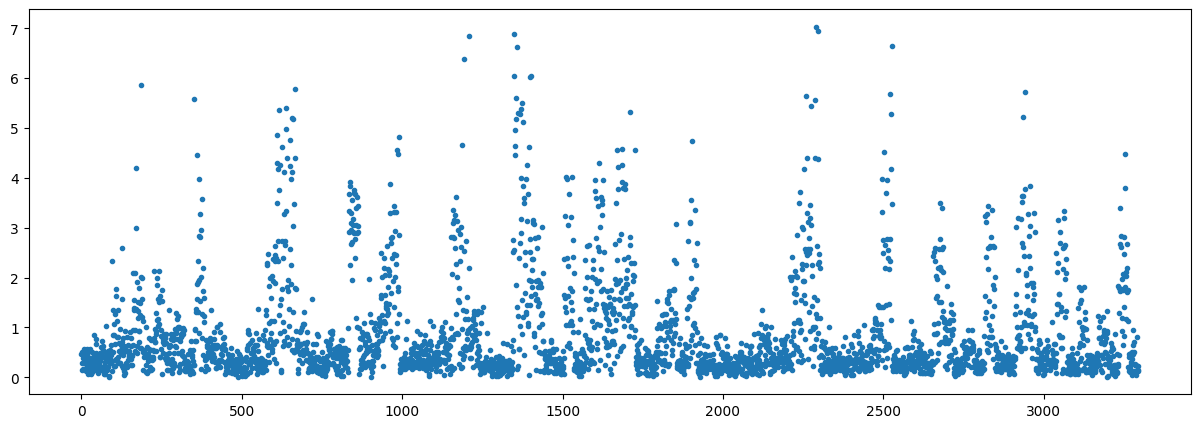

In [23]:
model.eval()
with torch.inference_mode():
    ypred = model(X_test.to(device))
Xtest = X_test.cpu().numpy()
ypred = ypred.cpu().numpy()
ytest = y_test.cpu().numpy()
err = ypred - ytest
err = np.sqrt(np.sum(err ** 2, axis=1))

plt.figure(figsize=(15, 5))
plt.plot(np.abs(err), '.')
#plt.ylim(0, 0.25)

In [24]:
# Aggregate the error over the inputs for each weight matrix
W_ = Xtest.reshape((-1, npts, 6))[:, 0, 2:]
err_ = np.abs(err.reshape((-1, npts)))
#err_ = np.sqrt(np.sum(err_ ** 2, axis=1))
err_ = np.max(err_, axis=1)
#W_.shape

# Eigenvalues
L = []
for i in range(W_.shape[0]):
    M = W_[i, :].reshape(2, 2)
    L_ = np.linalg.eigvals(M)
    L.append(L_)
L = np.stack(L)
#print(L.shape)

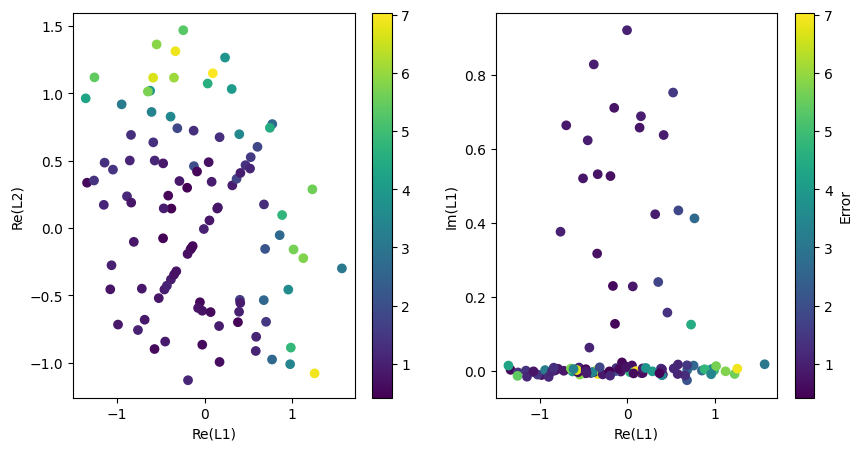

In [25]:
plt.figure(figsize=(10, 5))

#plt.scatter(W_[:, 3], W_[:, 2], c=err_, cmap='viridis')

plt.subplot(1, 2, 1)
#plt.scatter(np.abs(L[:, 0]), np.abs(L[:, 1]), c=err_, cmap='viridis')
plt.scatter(np.real(L[:, 0]), np.real(L[:, 1]), c=err_, cmap='viridis')
#plt.xlabel('|L1|')
#plt.ylabel('|L2|')
plt.xlabel('Re(L1)')
plt.ylabel('Re(L2)')
plt.colorbar()

plt.subplot(1, 2, 2)
n = L.shape[0]
q = np.random.normal(size=(n, 2)) * 0.01
plt.scatter(np.real(L[:, 0]) + q[:, 0],
            np.abs(np.imag(L[:, 0])) + q[:, 1],
            c=err_, cmap='viridis')
plt.xlabel('Re(L1)')
plt.ylabel('Im(L1)')
plt.colorbar(label='Error')

(3296, 2)
(3296,)


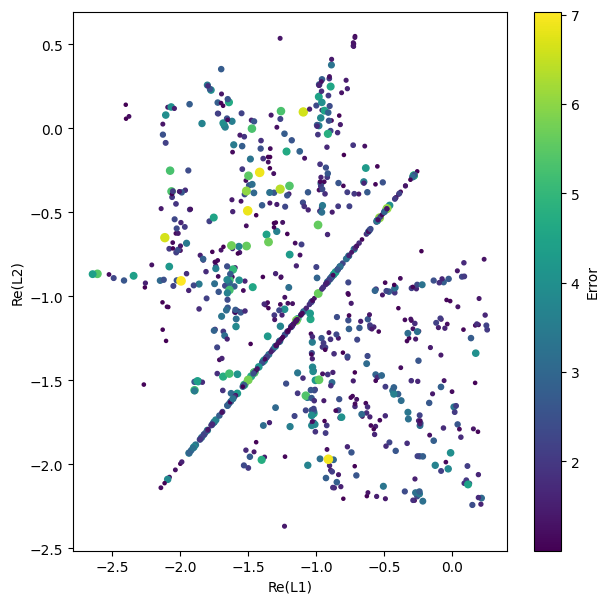

In [26]:
Lre = data['L_re'].values
Lre = np.roll(Lre, (d, 0))
Lre = Lre[n_train:, :]

print(Lre.shape)
print(err.shape)

mask = err > 1

plt.figure(figsize=(7, 7))
plt.scatter(Lre[mask, 0], Lre[mask, 1], s=err[mask] * 5,
            c=err[mask], cmap='viridis')
plt.xlabel('Re(L1)')
plt.ylabel('Re(L2)')
plt.colorbar(label='Error')


In [55]:
# Eigenvalues
ntest = Xtest.shape[0]
L = np.zeros((ntest, 2), dtype=np.complex128)
for n in range(ntest):
    M = Xtest[n, 2:].reshape(2, 2)
    L[n, :] = np.linalg.eigvals(M)

In [56]:
#np.real(L[idx[-50:], :])

lre_max = np.max(np.real(L), axis=1)
limg_max = np.max(np.imag(L), axis=1)

lre_abs_max = np.max(np.abs(np.real(L)), axis=1)
lre_abs_min = np.min(np.abs(np.real(L)), axis=1)

det = np.real(L[:, 0] * L[:, 1])
det_abs = np.abs(L[:, 0] * L[:, 1])

rmax = np.max(ytest, axis=1)
rmin = np.min(ytest, axis=1)

habs = np.sqrt(np.sum(Xtest[:, :2] ** 2, axis=1))
hmax = np.max(np.abs(Xtest[:, :2]), axis=1)

#rmax[idx[-50:]]

#plt.figure()
#plt.plot(lre_abs_max, hmax, '.')
#mask = err > 0.5
#plt.scatter(rmin[mask], rmax[mask], c=err[mask], cmap='viridis', s=err[mask]*2)
#plt.colorbar()
#plt.xlim(0, 2)
#plt.ylim(8, 10)
#plt.plot(rmax[mask], err[mask], '.')
#plt.plot(rmin[mask], err[mask], '.')
#plt.plot(det_abs[mask], err[mask], '.')



In [57]:
idx = np.argsort(err)[::-1]

df = pd.DataFrame({
    'err': err,
    'lre_max': lre_max,
    'limg_max': limg_max,
    'rmax': rmax,
    'rmin': rmin,
    'habs': habs,
    'hmax': hmax,
    'lre_abs_max': lre_abs_max,
    'lre_abs_min': lre_abs_min,
    'det': det,
    'det_abs': det_abs
})

dirpath_out = dirpath_root / 'model' / fname
os.makedirs(dirpath_out, exist_ok=True)
fname_csv = f'nout={n_out}_roll={d}_nhid_{NLAYERS_HID}_szhid_{HIDDEN_SZ}_batch_{BATCH_SIZE}_lr_{LR:.04f}_ep_{EPOCHS}.csv'
fpath_csv = dirpath_out / fname_csv
df.to_csv(fpath_csv)
print(f"Data saved to {fpath_csv}")

display(df.loc[idx].head(20))

Data saved to /content/drive/MyDrive/repo/pytorch_test/model/rates_npops_2_nmodels_512_npts_32_seed_113_ws_1_uni_r_0.1_9.9_dt_0.25_nt_100/nout=2_roll=10048_nhid_2_szhid_128_batch_128_lr_0.0010_ep_2000.csv


,err,lre_max,limg_max,rmax,rmin,habs,hmax,lre_abs_max,lre_abs_min,det,det_abs
2816,9.571578,1.442200,0.000000,9.870197,9.188786,10.360356,9.662252,1.442200,0.097996,-0.141330,0.141330
1482,7.886230,0.895173,0.000000,3.344005,2.642215,6.064114,5.228498,0.895173,0.083910,-0.075114,0.075114
2223,7.839066,1.050647,0.000000,8.635082,0.399400,1.367226,1.274220,1.050647,0.129539,-0.136100,0.136100
2835,7.764478,1.442200,0.000000,1.855328,0.139197,11.156682,10.138013,1.442200,0.097996,-0.141330,0.141330
435,7.570428,1.243436,0.000000,9.470325,0.515331,0.909079,0.867838,1.243436,0.114320,-0.142149,0.142149
2827,7.294398,1.442200,0.000000,9.808150,7.006702,11.174586,9.847975,1.442200,0.097996,-0.141330,0.141330
1563,7.141270,1.089627,0.000000,8.623061,6.681839,7.735791,7.706959,1.089627,0.425122,-0.463225,0.463225
3095,6.894336,1.073895,0.000000,2.748948,0.556004,8.350745,8.034016,1.073895,0.410881,-0.441243,0.441243
1557,6.476322,1.089627,0.000000,9.528290,9.084434,6.827461,6.825338,1.089627,0.425122,-0.463225,0.463225
1185,6.391693,1.398553,0.000000,9.119618,0.326058,5.392054,4.214328,1.398553,0.469556,0.656699,0.656699


In [ ]:
sz = 10
nfeat = X.shape[1]
x = np.linspace(-3, 3, sz)
grids = np.meshgrid(*((x,) * nfeat))
Xtest = np.stack([g.ravel() for g in grids], axis=1)
Xtest = torch.from_numpy(Xtest).type(torch.float)

model.eval()   # switch to evaluation mode
with torch.inference_mode():
    ytest = model(Xtest.to(device))

ytest = ytest.cpu().numpy().reshape((sz,) * nfeat)

In [ ]:
plt.figure()
ext = (-3, 3, -3, 3)
m = 0
n = 3
cc = [0] * nfeat
cc[m], cc[n] = slice(None), slice(None)
plt.imshow(ytest[*cc], extent=ext, origin='lower', cmap='viridis')
plt.colorbar(label='Predicted y')
plt.xlabel('xn')
plt.ylabel('xm')
plt.title('Heatmap of Predicted y')
plt.show()

In [ ]:
import warnings
from sklearn.decomposition import PCA
from sklearn.manifold import Isomap
from scipy.sparse import SparseEfficiencyWarning

warnings.filterwarnings("ignore", category=SparseEfficiencyWarning)

W0 = data0['W'].values.reshape((-1, 4))

iso = Isomap(n_components=2, n_neighbors=10)
W2 = iso.fit_transform(W)

#W2 = PCA(n_components=2).fit_transform(W0)

plt.figure()
plt.plot(W2[:, 0], W2[:, 1], '.')
